# Telco Churn Prediction - EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from heatmap import heatmap, corrplot


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from collections import Counter
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier

pd.set_option('display.max_columns', 500)

path = 'https://huggingface.co/datasets/scikit-learn/churn-prediction/raw/main/dataset.csv'

Load and Transform Data

In [2]:
df = pd.read_csv(path);
print(df.info())

# Encoding categorical columns
cat_cols = ['gender','Partner','Dependents','PhoneService','MultipleLines',
                      'InternetService','OnlineSecurity',	'OnlineBackup',	'DeviceProtection',	
                      'TechSupport', 'StreamingTV','StreamingMovies','PaperlessBilling',
                      'StreamingTV','Contract', 'PaymentMethod']
# Column TotalCharges is a string, have to convert to numeric
print(df[df.TotalCharges ==' '].index)
df.TotalCharges = df.TotalCharges.apply([lambda x: float(x) if x!= ' ' else x]) # make float if value exists
mean = pd.to_numeric(df.TotalCharges, errors='coerce').mean()
df.TotalCharges = df.TotalCharges.apply([lambda x: mean if x == ' ' else x ]) # replace ' ' with mean of this column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Missing Data Check

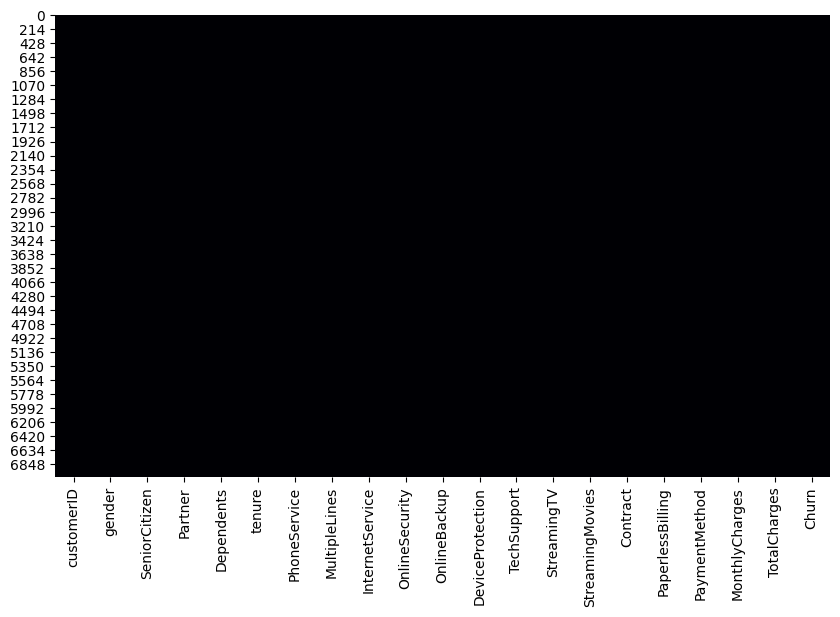

<Figure size 1000x600 with 0 Axes>

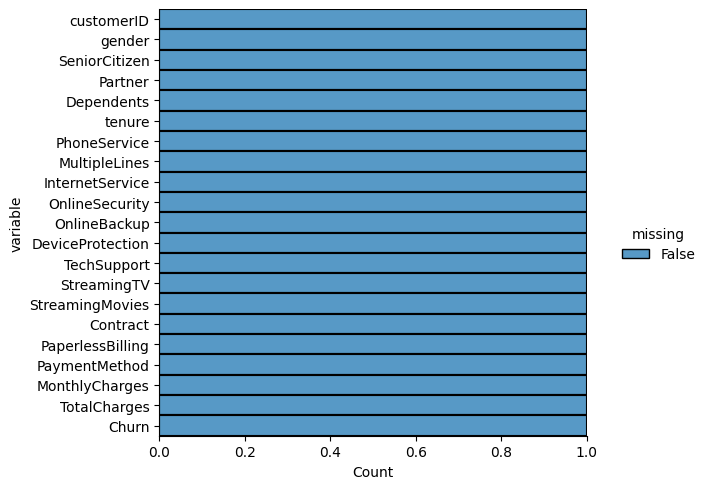

In [3]:
#Confirming there are no missing values
fig, ax = plt.subplots(figsize = (10,6))
sns.heatmap(df.isnull(),cmap = 'magma',cbar = False, ax = ax);
# Another way using distplot:
plt.figure(figsize = (10,6))
sns.displot(
    data = df.isna().melt(value_name='missing'),
    y = 'variable',
    hue = 'missing',
    multiple = 'fill',
    aspect = 1.25,
)

# Visualisations

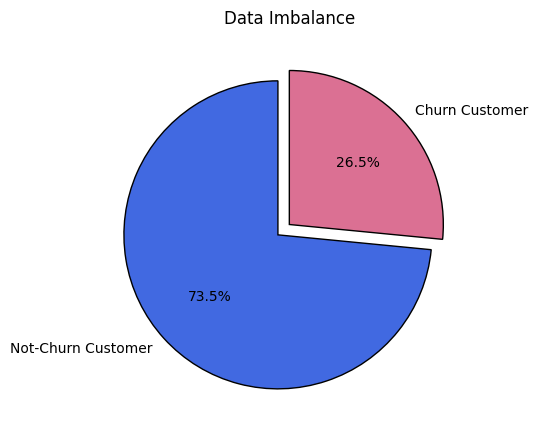

In [4]:
#sns.set_theme(palette="pastel")
colors = ['royalblue','palevioletred']
l = list(df['Churn'].value_counts())
circle = [l[0] / sum(l) * 100,l[1] / sum(l) * 100]

fig, ax = plt.subplots(figsize = (10,5))
plt.pie(circle,labels = ['Not-Churn Customer','Churn Customer'],autopct = '%1.1f%%',startangle = 90,explode = (0.1,0),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True}, colors = colors)
plt.title('Data Imbalance');

In [5]:
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

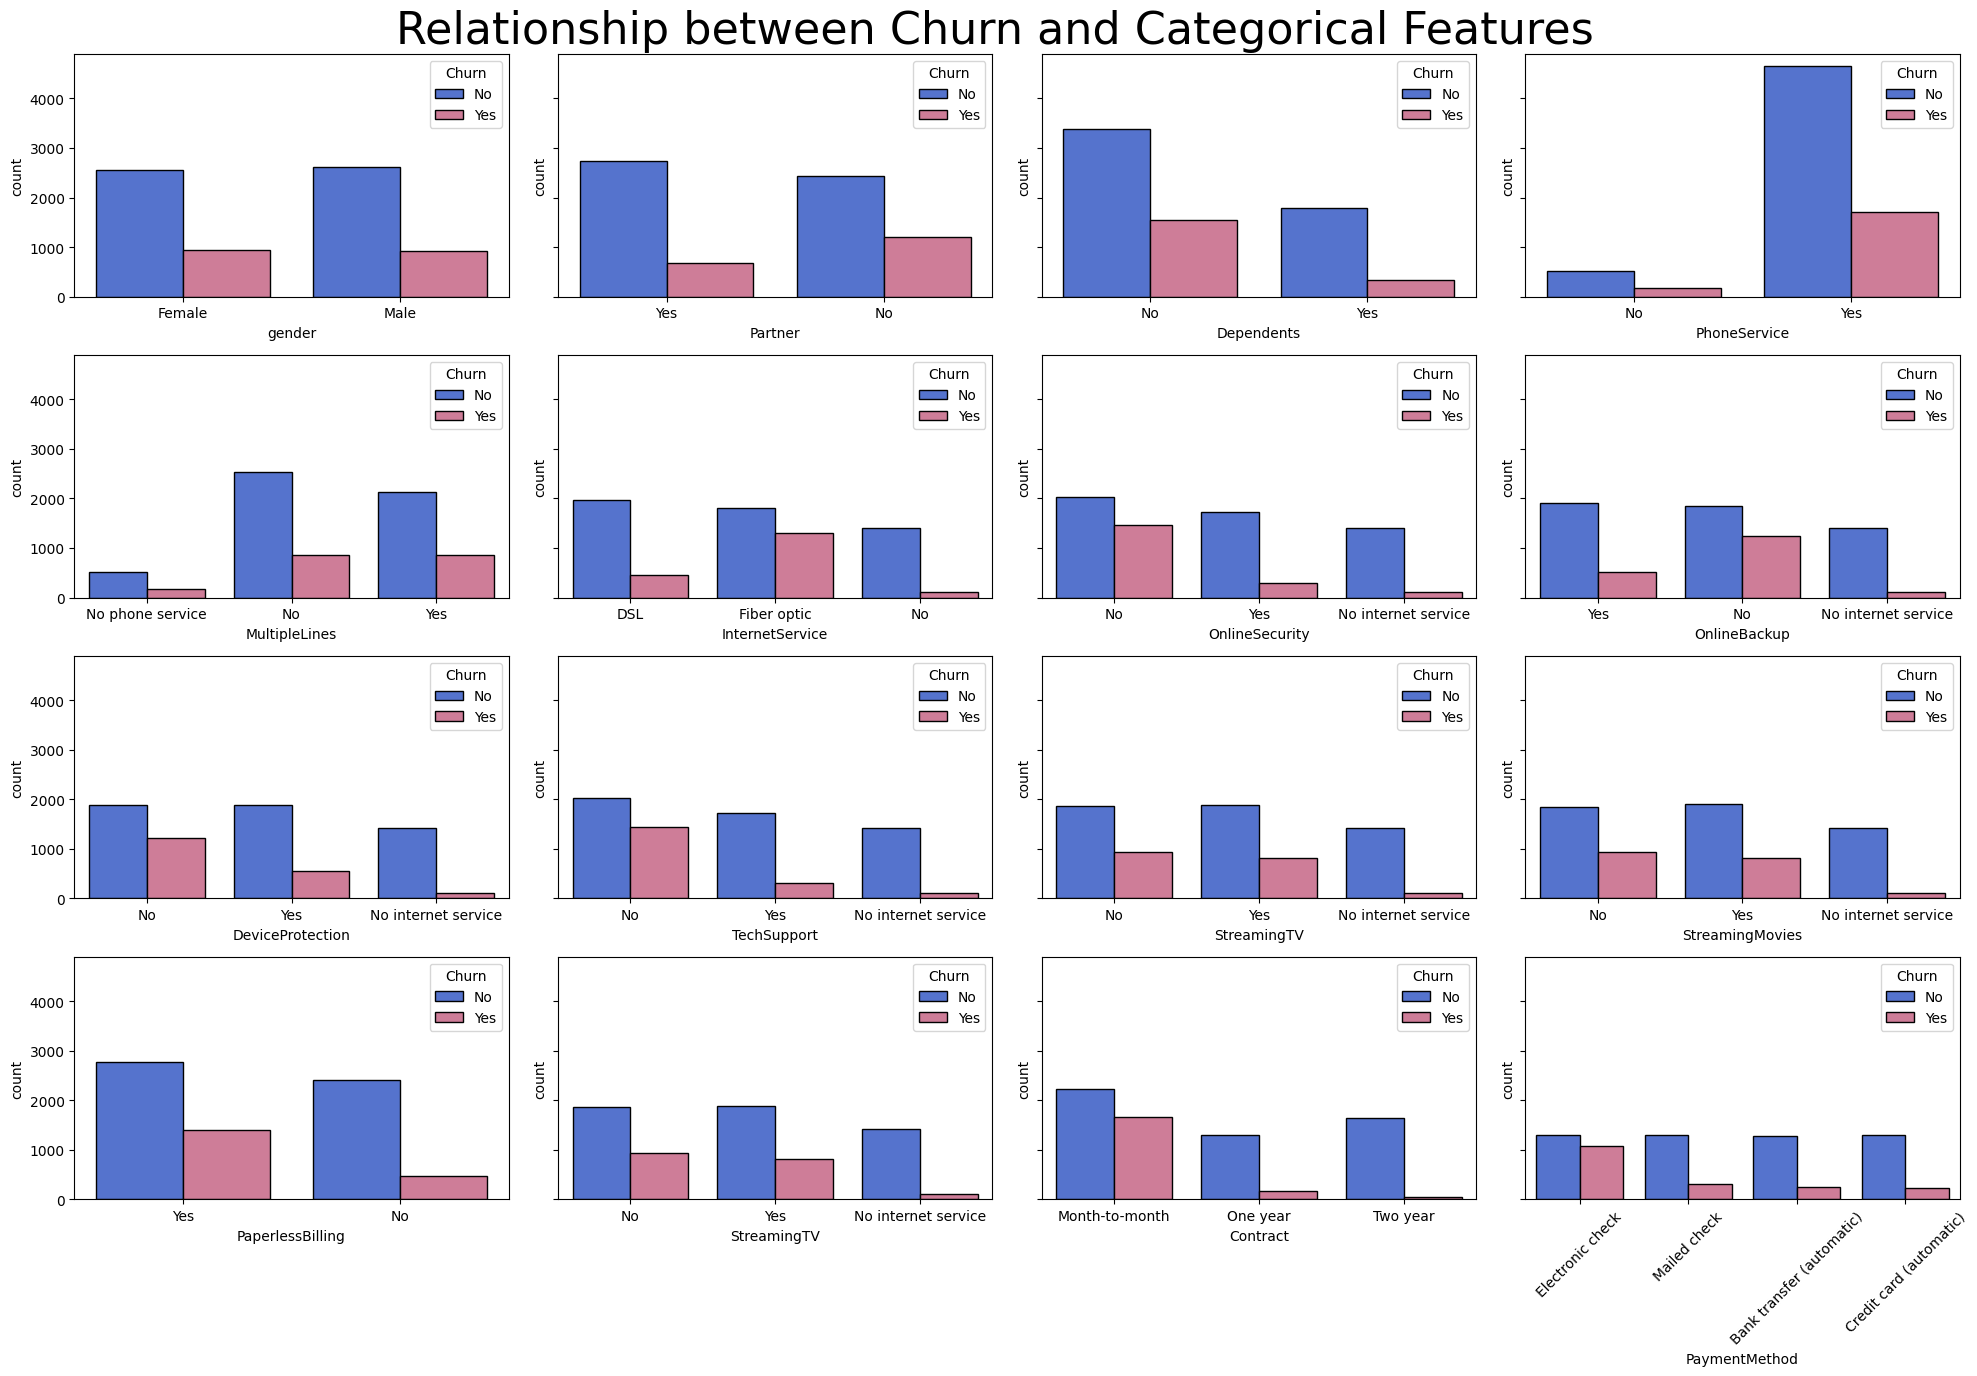

In [6]:
fig,ax = plt.subplots(4,4,figsize = (20,14), sharex=False, sharey=True)
for i in range(len(cat_cols)):
    ax = ax.flatten()
    #ax[i] = plt.subplot(1,1,i+1)
    sns.countplot(x = cat_cols[i],data = df,hue = "Churn",edgecolor = 'black', ax = ax[i], palette=colors)
    if i == 15:
        ax[i].set_xticklabels(labels= df['PaymentMethod'].unique() , rotation=45)
    else: 
        pass
fig.suptitle('Relationship between Churn and Categorical Features', fontsize=32);
plt.tight_layout()


Checking Numerical Features

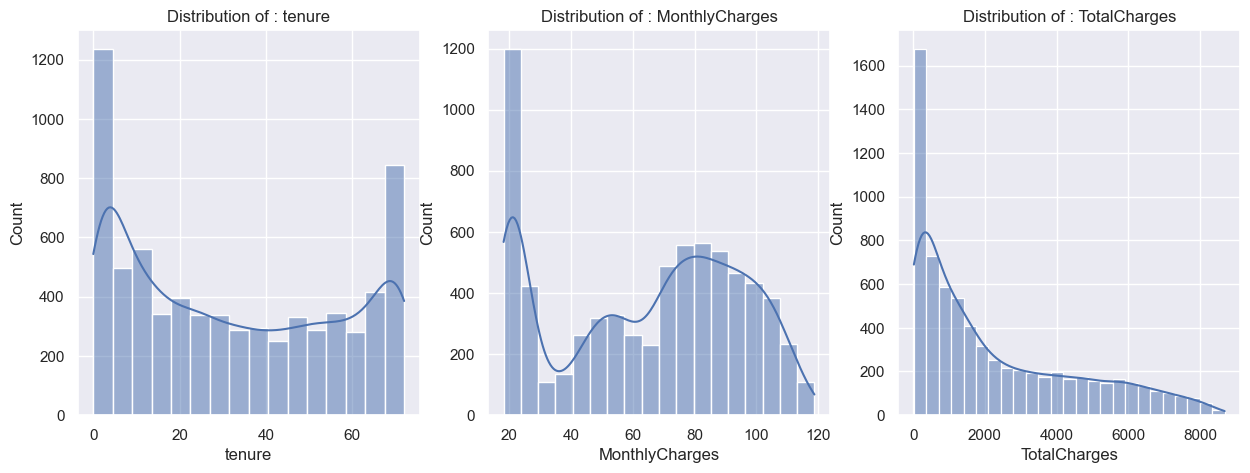

In [7]:
sns.set_theme(style='darkgrid')

num_cols = ['tenure','MonthlyCharges','TotalCharges'] # numerical columns 

fig, ax = plt.subplots( 1, 3,figsize = (15,5))

for i in range(len(num_cols)):
    plt.subplot(1,3,i+1)
    sns.histplot(df[num_cols[i]], kde=True)
    title = 'Distribution of : ' + num_cols[i]
    plt.title(title)
plt.show()

Numerical and Categorical Features Compared 

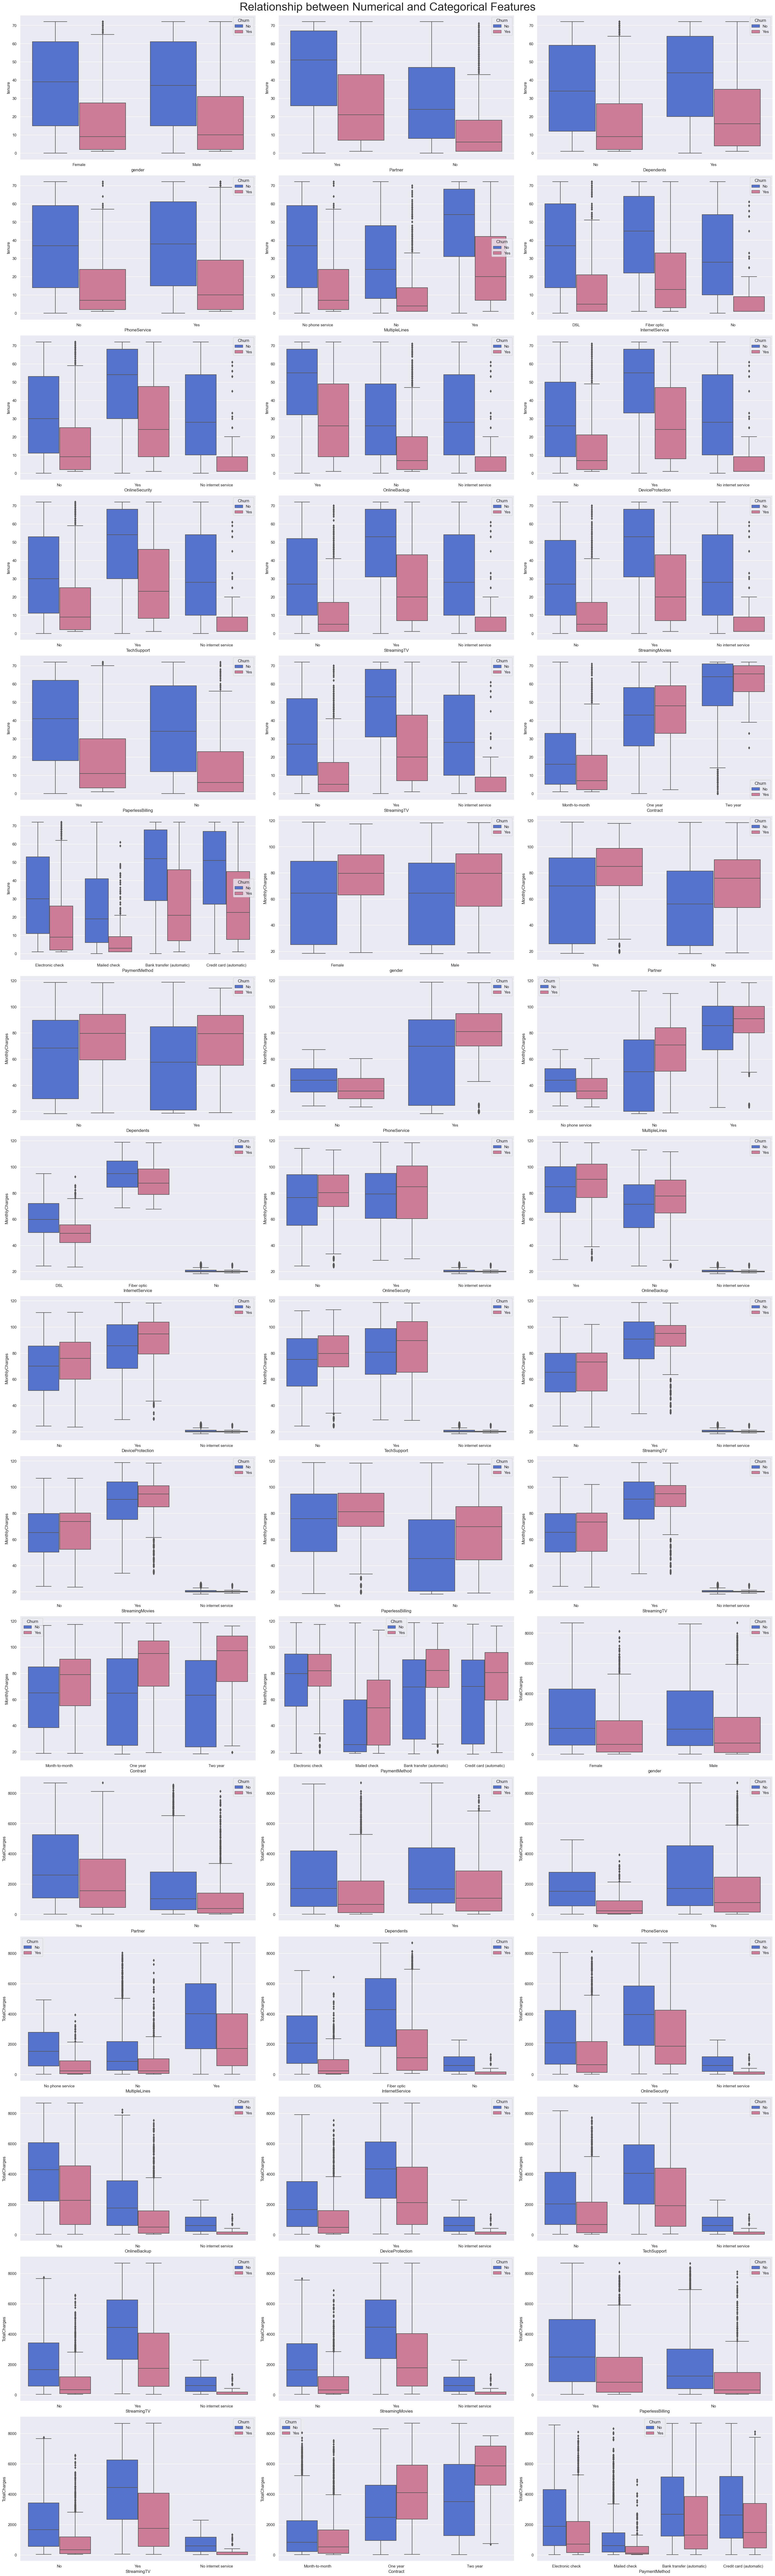

In [8]:
fig,ax = plt.subplots(16,3,figsize = (30,100),layout="constrained")
ax = ax.flatten()
k=0
for i in range(len(num_cols)):
    for j in range(len(cat_cols)):
        sns.boxplot(data = df, x = cat_cols[j], y = num_cols[i], hue = "Churn", ax = ax[k], palette=colors)
        k+=1
fig.suptitle('Relationship between Numerical and Categorical Features', fontsize=32);

Order / Values of features for customer churn cases :
- Categorical Features (Order) :
- gender : Male = Female
- SeniorCitizen : No SeniorCitizen > SeniorCitizen
- Partner : No Partner > Partner
- Dependents : No Dependent > Dependent
- PhoneService : PhoneService > No PhoneService
- MultipleLines : MultipleLines > No MultipleLines > No PhoneService
- InternetService : Fiber Optic > DSL > No InternetService
- OnlineSecurity : Absent > Present > No InternetService
- OnlineBackup : Absent > Present > No InternetService
- DeviceProtection : Absent > Present > No InternetService
- TechSupport : Absent > Present > No InternetService
- StreamingTV : Absent > Present > No InternetService
- StreamingMovies : Absent > Present > No InternetService
- Contract : Month-to-Month > One year > Two year
- PaperlessBilling : Present > Absent
- PaymentMethod : Electronic check > Mailed check > Bank Transfer (automatic) > Credit Card (automatic)!

Numerical Features (Range) :
- tenure : 1 - 5 months
- MonthlyCharges : 65 - 105
- TotalCharges : 0 - 1000

According to the EDA, these order / range of values results in customer churn!

# Feature Engineering
## Encoding

In [9]:
edf = df.copy(deep=True) # edef for engineered df
# Encoding Categorical Columns
ord_enc = OrdinalEncoder()
edf[cat_cols] = ord_enc.fit_transform(df[cat_cols]).copy() 
# Mapping the target (Churn column)
lb = LabelEncoder()
edf['Churn'] = lb.fit_transform(df['Churn'])

## Scaling

In [10]:
mms = MinMaxScaler() # Normalisation using min max scaler

edf['tenure'] = mms.fit_transform(edf[['tenure']])
edf['MonthlyCharges'] = mms.fit_transform(edf[['MonthlyCharges']])
edf['TotalCharges'] = mms.fit_transform(edf[['TotalCharges']])

A much cleaner apprach for correlation plot heatmaps

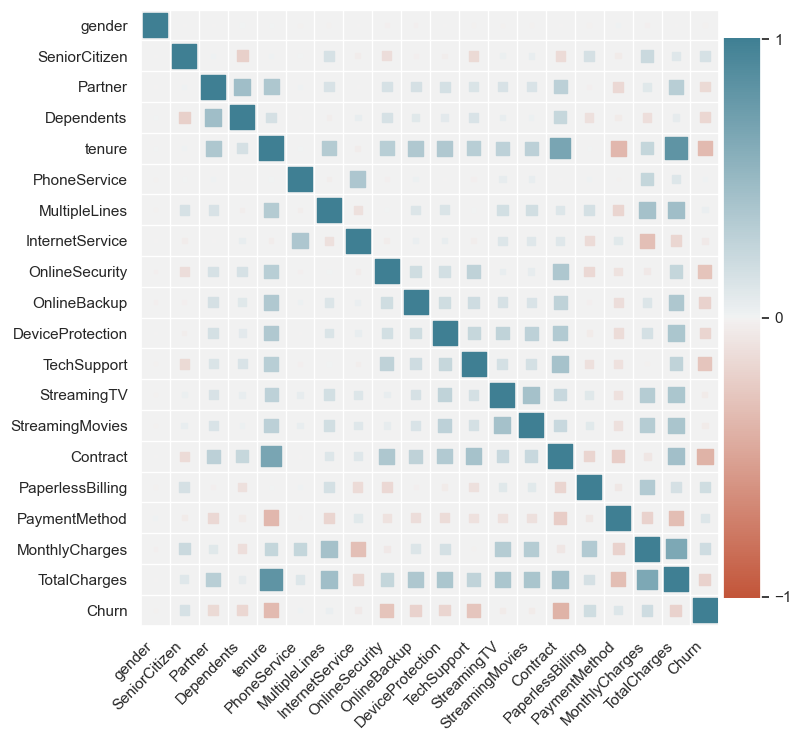

In [11]:
plt.figure(figsize=(8, 8))
corrplot(edf.corr(numeric_only =True), size_scale=300);

<Axes: >

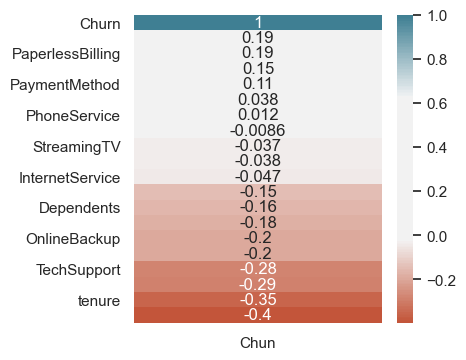

In [12]:
corr = edf.corrwith(edf['Churn'], numeric_only=True)
corr.sort_values(ascending=False, inplace=True)
corr = pd.DataFrame(corr, columns = ['Chun'])

fig, ax = plt.subplots(figsize = (4,4))
sns.heatmap(corr, annot=True ,cmap=sns.diverging_palette(20, 220, n=200, sep = 120))

Fixed the colour bar to show what the actual correlations with churn are. 

## Feature Selection

### Chi-Squared Test:

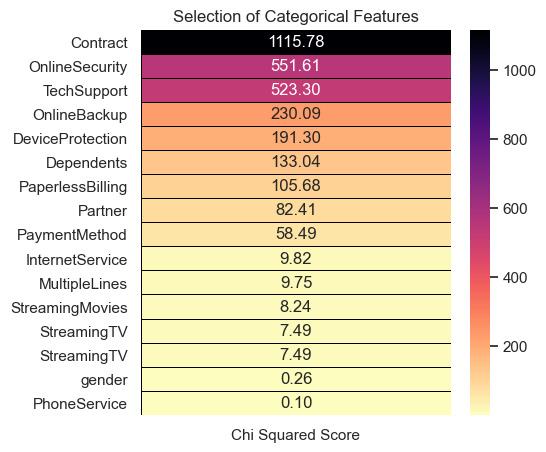

In [13]:
features = edf.loc[:,cat_cols]
target = edf.loc[:,'Churn']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),
            annot = True,cmap = sns.color_palette("magma_r", as_cmap=True),
            linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features');

We will drop anything with score below 10.
 ### ANOVA Test for numerical features

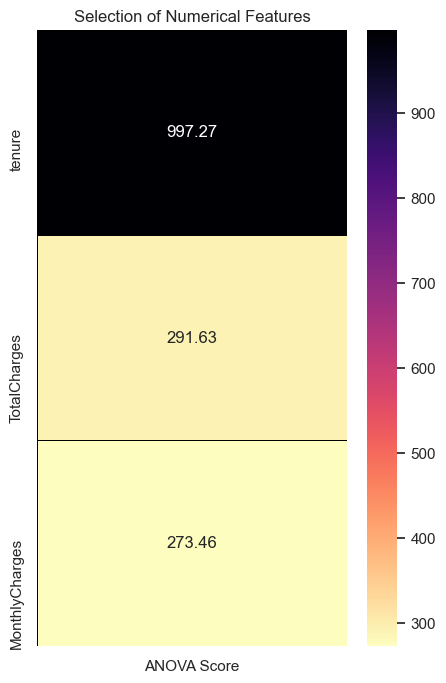

In [14]:
features = edf.loc[:,num_cols]
target = edf.loc[:,'Churn']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,8))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),
cmap = sns.color_palette("magma_r", as_cmap=True),annot = True,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

All the socres are high we will keep them. 

Gtting the dataframe ready for modelling:

In [15]:
edf.drop(['customerID', 'gender','PhoneService', 'MultipleLines', 'InternetService','StreamingTV', 'StreamingMovies'], axis = 1, inplace=True)

In [16]:
edf.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn'],
      dtype='object')

In [17]:
edf.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1.0,0.0,0.013889,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.115423,0.001275,0
1,0,0.0,0.0,0.472222,2.0,0.0,2.0,0.0,1.0,0.0,3.0,0.385075,0.215867,0
2,0,0.0,0.0,0.027778,2.0,2.0,0.0,0.0,0.0,1.0,3.0,0.354229,0.010310,1
3,0,0.0,0.0,0.625000,2.0,0.0,2.0,2.0,1.0,0.0,0.0,0.239303,0.210241,0
4,0,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.521891,0.015330,1


## Balancing the Data with imblearn

Synthetic Minority Oversampling Technique (SMOTE)
A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.

In [18]:
oversample = SMOTE(sampling_strategy=1) # same sample size
f1 = edf.iloc[:,:13].values
t1 = edf.iloc[:,13].values
f1, t1 = oversample.fit_resample(f1, t1)
Counter(t1)

Counter({0: 5174, 1: 5174})

In [19]:
edf.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1.0,0.0,0.013889,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.115423,0.001275,0
1,0,0.0,0.0,0.472222,2.0,0.0,2.0,0.0,1.0,0.0,3.0,0.385075,0.215867,0
2,0,0.0,0.0,0.027778,2.0,2.0,0.0,0.0,0.0,1.0,3.0,0.354229,0.010310,1
3,0,0.0,0.0,0.625000,2.0,0.0,2.0,2.0,1.0,0.0,0.0,0.239303,0.210241,0
4,0,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.521891,0.015330,1


# Models
To ease the comparison, we define the train and evaluate functions below.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(f1, t1, test_size = 0.20, random_state = 2)

In [30]:
def train(model,x_train,y_train,x_test,y_test):
    
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(model,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    RocCurveDisplay.from_estimator(model, x_test,y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

def evaluate(model,x_test,y_test):
    # Confusion Matrix
    cm = confusion_matrix(y_test,model.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,model.predict(x_test)))

XGBoost

Cross Validation Score :  90.16%
ROC_AUC Score :  82.92%


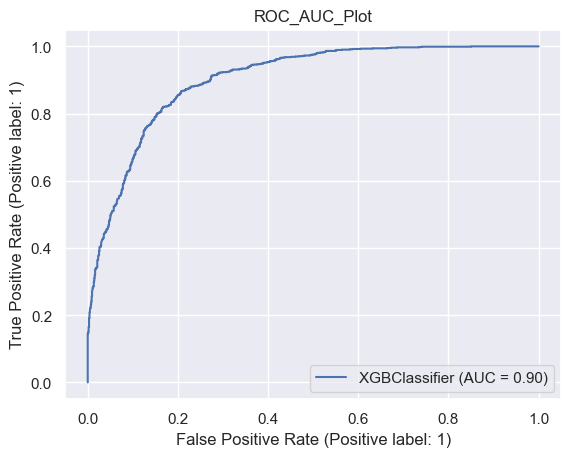

In [19]:
xgb_model = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
train(xgb_model,x_train,y_train,x_test,y_test)

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1040
           1       0.81      0.87      0.83      1030

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



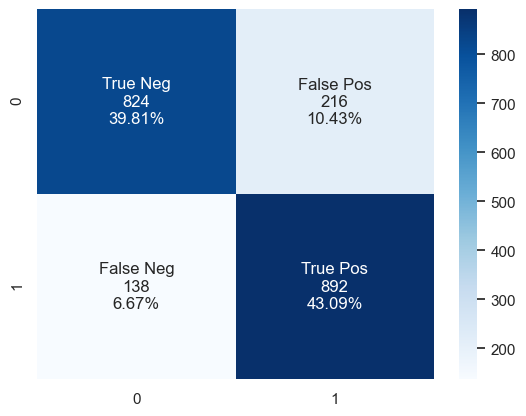

In [20]:
evaluate(xgb_model,x_test,y_test)

LGBM

Cross Validation Score :  90.29%
ROC_AUC Score :  82.72%


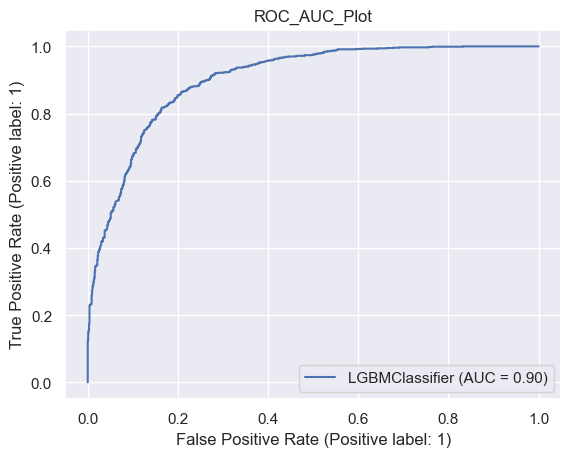

In [21]:
lgbm_model = LGBMClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
train(lgbm_model,x_train,y_train,x_test,y_test)

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1040
           1       0.80      0.86      0.83      1030

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



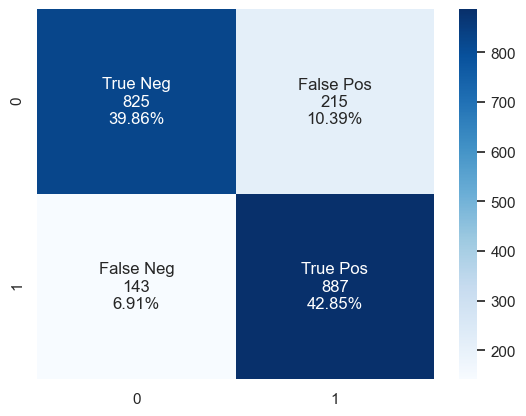

In [22]:
evaluate(lgbm_model,x_test,y_test)

Random Forrest

Cross Validation Score :  85.50%
ROC_AUC Score :  78.44%


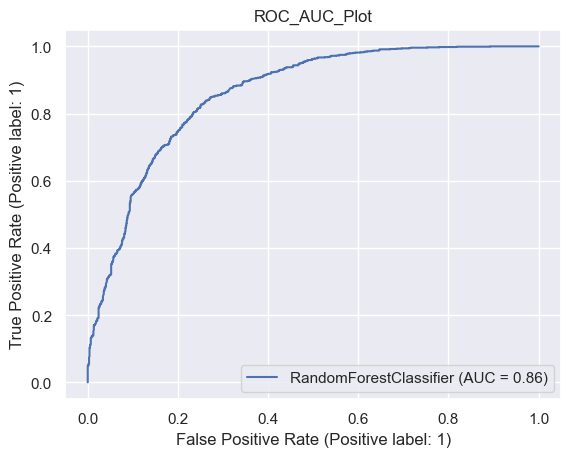

In [23]:
rf_model = RandomForestClassifier(max_depth = 4,random_state = 0)
train(rf_model, x_train,y_train,x_test,y_test)

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1040
           1       0.75      0.85      0.80      1030

    accuracy                           0.78      2070
   macro avg       0.79      0.78      0.78      2070
weighted avg       0.79      0.78      0.78      2070



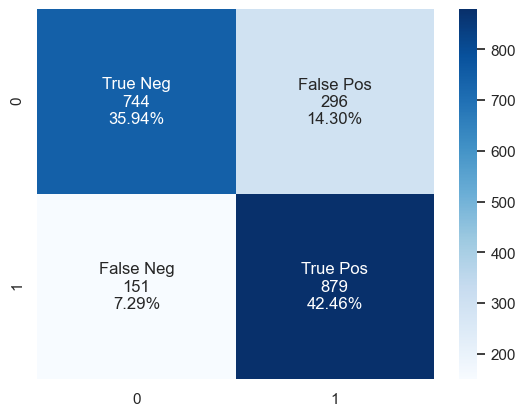

In [24]:
evaluate(rf_model,x_test,y_test)

Decision Tree

Cross Validation Score :  83.92%
ROC_AUC Score :  78.22%


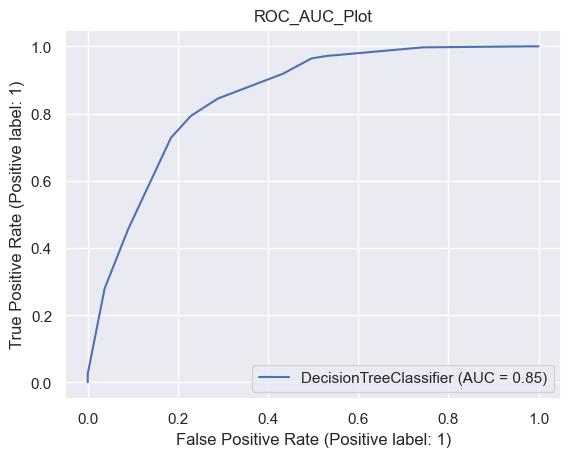

In [25]:
dt_model = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)
train(dt_model, x_train,y_train,x_test,y_test)

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1040
           1       0.77      0.79      0.78      1030

    accuracy                           0.78      2070
   macro avg       0.78      0.78      0.78      2070
weighted avg       0.78      0.78      0.78      2070



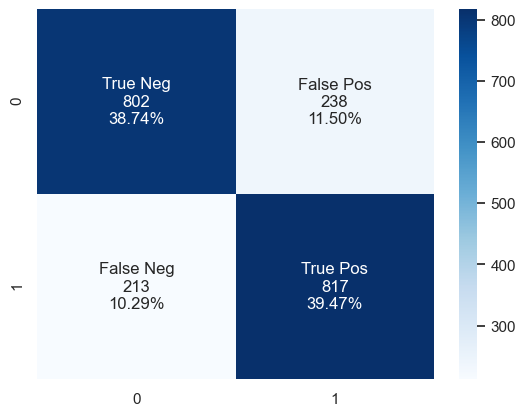

In [26]:
evaluate(dt_model,x_test,y_test)

Stacking Models

In [27]:
stack = StackingClassifier(estimators = [('xgb_model',xgb_model),
                                         ('lgbm_model',lgbm_model),
                                         ('rf_model',rf_model),
                                         ('dt_model',dt_model)],
                        final_estimator = dt_model)

Cross Validation Score :  90.19%
ROC_AUC Score :  82.31%


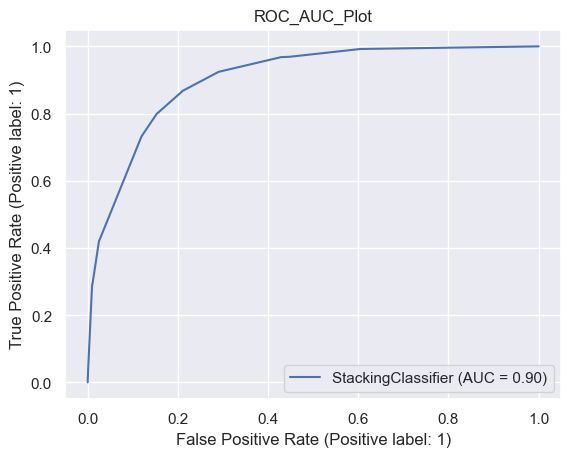

In [28]:
train(stack,x_train,y_train,x_test,y_test)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1040
           1       0.84      0.80      0.82      1030

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.82      0.82      0.82      2070



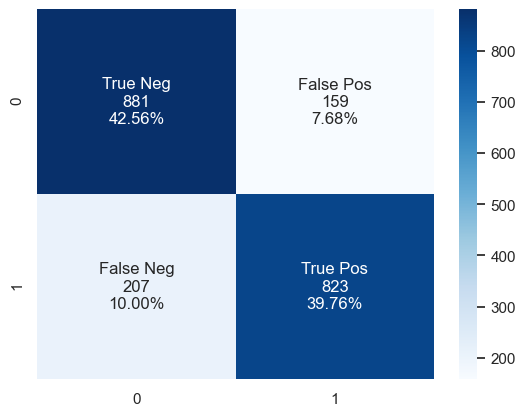

In [29]:
evaluate(stack,x_test,y_test)

Insights:

Senior Citizenas and Living wiht a Partner contribute to the churn rate.
Electronic Checque payments are a significant contributer to churn.
The perceived limit for the monthly charge is around the 70 mark, more than that and the customer will have a higher probability of churn.

Best model is the XGBoost model and we will use this for production in Azure.